# Cross-lingual Valence Universality in Colexification

**Core question:** Why is valence the most cross-linguistically consistent cognitive rating
in colexified concept pairs — and what does that tell us about the cognitive basis of colexification?

### Analysis structure
1. Baseline: cross-lingual r heatmap across all rating types
2. Colexified vs. random pairs: is valence similarity specific to colexification?
3. Valence similarity as a colexification predictor (ROC / AUC)
4. Within-edge cross-lingual consistency: universal vs. culture-specific colex pairs
5. Language-family effects on valence agreement
6. Language overlap: does colexifying *in* a language strengthen its valence alignment?
7. Valence polarity of colexified vs. random pairs


In [1]:
import json, warnings
import numpy as np
import scipy.sparse as sp
import scipy.stats as stats
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from pathlib import Path
from collections import defaultdict

warnings.filterwarnings("ignore")
np.random.seed(42)

MERGED_DIR = Path("../case-studies/linking-datasets/graphs/merged")
RATING_TYPES = ["valence","arousal","dominance","AoA","imageability",
                "familiarity","frequency","concreteness","emotionality"]

with (MERGED_DIR / "index.json").open() as f:
    INDEX = json.load(f)

# BabelNet uppercase → norare lowercase mapping used in colex edges
LANG_FAMILIES = {
    "en": "Germanic", "de": "Germanic", "nl": "Germanic",
    "es": "Romance",  "fr": "Romance",  "it": "Romance", "pt": "Romance",
    "pl": "Slavic",
    "tr": "Turkic",
    "zh": "Sino-Tibetan",
}

def load_merged(rt):
    with (MERGED_DIR / f"{rt}.json").open() as f: return json.load(f)

# Load valence once — used throughout
print("Loading valence graph...")
GV = load_merged("valence")
LANGS_V = INDEX["valence"]["rated_langs"]
print(f"  {len(GV['nodes'])} nodes, {len(GV['edges'])} edges, {len(LANGS_V)} languages: {LANGS_V}")


Loading valence graph...


  2942 nodes, 39972 edges, 10 languages: ['de', 'en', 'es', 'fr', 'it', 'nl', 'pl', 'pt', 'tr', 'zh']


In [2]:
# ── Shared helpers ────────────────────────────────────────────────────────

def lang_pair_r(g, la, lb):
    """Pearson r of mean_z between two languages across all concepts rated in both."""
    za, zb = [], []
    for node in g["nodes"].values():
        va = node["mean_z"].get(la)
        vb = node["mean_z"].get(lb)
        if va is not None and vb is not None:
            za.append(va); zb.append(vb)
    if len(za) < 30:
        return float("nan"), 0
    return float(np.corrcoef(za, zb)[0, 1]), len(za)

def edge_zdiff_series(g, la, lb):
    """For colex edges rated in both languages: returns (zdiff, n_colex_langs, colex_langs) arrays."""
    diffs, strengths, colex_lang_lists = [], [], []
    for e in g["edges"]:
        d = e["abs_z_diff_per_lang"]
        if la in d and lb in d:
            diffs.append((d[la] + d[lb]) / 2)
            strengths.append(e["n_languages"])
            colex_lang_lists.append(set(l.lower() for l in e["colex_languages"]))
    return np.array(diffs), np.array(strengths), colex_lang_lists

def random_pair_zdiff(g, la, lb, n_samples=5000):
    """Sample random non-colexified concept pairs and compute |z_la - z_lb|."""
    colex_pairs = {(min(e["source"],e["target"]), max(e["source"],e["target"]))
                   for e in g["edges"]}
    # Concepts rated in both languages
    rated_both = [cid for cid, n in g["nodes"].items()
                  if la in n["mean_z"] and lb in n["mean_z"]]
    if len(rated_both) < 10:
        return np.array([])
    cids = np.array(rated_both)
    diffs = []
    tries = 0
    while len(diffs) < n_samples and tries < n_samples * 20:
        i, j = np.random.choice(len(cids), 2, replace=False)
        a, b = cids[i], cids[j]
        pair = (min(a, b), max(a, b))
        if pair not in colex_pairs:
            za = g["nodes"][a]["mean_z"][la]
            zb = g["nodes"][b]["mean_z"][lb]
            diffs.append(abs(za - zb))
        tries += 1
    return np.array(diffs)

print("Helpers defined.")


Helpers defined.


## Part 1 — Cross-lingual r heatmap: which rating type is most universal?

Mean cross-lingual r by rating type:
  valence         r̄ = 0.856
  imageability    r̄ = 0.757
  arousal         r̄ = 0.641
  AoA             r̄ = 0.616
  frequency       r̄ = 0.499
  dominance       r̄ = 0.426
  familiarity     r̄ = 0.276
  concreteness    r̄ = 0.186


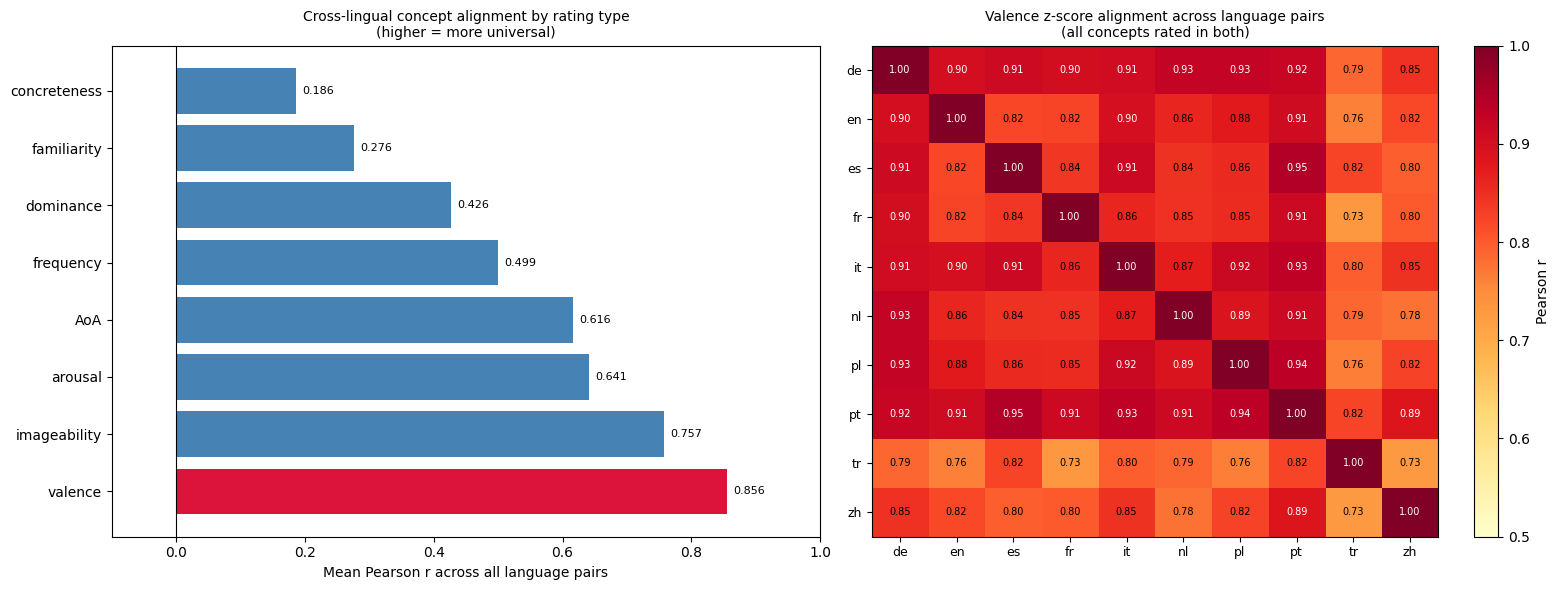


Valence r range: 0.730 – 0.946
Turkish pairs are lowest — likely least overlap in concept coverage.


In [3]:
# Compute r for every rating_type × language pair
r_data = {}   # (rt, la, lb) -> r

for rt in RATING_TYPES:
    if rt not in INDEX: continue
    g = load_merged(rt)
    langs = INDEX[rt]["rated_langs"]
    for i, la in enumerate(langs):
        for lb in langs[i+1:]:
            r, n = lang_pair_r(g, la, lb)
            if not np.isnan(r) and n >= 50:
                r_data[(rt, la, lb)] = r

# Build summary: mean r per rating type (across all language pairs)
rt_mean_r = {}
for rt in RATING_TYPES:
    vals = [v for (t,_,__),v in r_data.items() if t==rt]
    if vals: rt_mean_r[rt] = np.mean(vals)

print("Mean cross-lingual r by rating type:")
for rt, r in sorted(rt_mean_r.items(), key=lambda x:-x[1]):
    print(f"  {rt:<14}  r̄ = {r:.3f}")

# Heatmap for valence (best type) — all language pairs
langs_v = LANGS_V
n_l = len(langs_v)
R_val = np.full((n_l, n_l), np.nan)
for i, la in enumerate(langs_v):
    R_val[i, i] = 1.0
    for j, lb in enumerate(langs_v):
        if i < j:
            r = r_data.get(("valence", la, lb), r_data.get(("valence", lb, la), float("nan")))
            R_val[i, j] = R_val[j, i] = r

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: mean r bar chart
ax = axes[0]
types_sorted = sorted(rt_mean_r, key=lambda x: -rt_mean_r[x])
colors = ["crimson" if t=="valence" else "steelblue" for t in types_sorted]
ax.barh(types_sorted, [rt_mean_r[t] for t in types_sorted], color=colors)
ax.axvline(0, color="black", lw=0.8)
ax.set_xlabel("Mean Pearson r across all language pairs", fontsize=10)
ax.set_title("Cross-lingual concept alignment by rating type\n(higher = more universal)", fontsize=10)
ax.set_xlim(-0.1, 1.0)
for i, t in enumerate(types_sorted):
    ax.text(rt_mean_r[t]+0.01, i, f"{rt_mean_r[t]:.3f}", va="center", fontsize=8)

# Right: valence language-pair r heatmap
ax2 = axes[1]
im = ax2.imshow(R_val, vmin=0.5, vmax=1.0, cmap="YlOrRd", aspect="auto")
ax2.set_xticks(range(n_l)); ax2.set_xticklabels(langs_v, fontsize=9)
ax2.set_yticks(range(n_l)); ax2.set_yticklabels(langs_v, fontsize=9)
for i in range(n_l):
    for j in range(n_l):
        if not np.isnan(R_val[i,j]):
            ax2.text(j, i, f"{R_val[i,j]:.2f}", ha="center", va="center",
                     fontsize=7, color="white" if R_val[i,j]>0.88 else "black")
fig.colorbar(im, ax=ax2, label="Pearson r")
ax2.set_title("Valence z-score alignment across language pairs\n(all concepts rated in both)", fontsize=10)

plt.tight_layout(); plt.show()
print(f"\nValence r range: {np.nanmin(R_val[R_val<1]):.3f} – {np.nanmax(R_val[R_val<1]):.3f}")
print(f"Turkish pairs are lowest — likely least overlap in concept coverage.")


## Part 2 — Colexified vs. random pairs: is valence similarity specific to colexification?

## Part 1b — Graph Signal Processing: valence as a smooth signal on the colexification graph

Use the colexification graph as topology and the valence z-scores as a graph signal.

- **Rayleigh quotient** R = xᵀLx / xᵀx measures smoothness: low R → connected concept pairs have similar valence
- **Permutation test**: shuffle signal 2000× to get a null distribution; z-score tells how much smoother than random
- **Graph Fourier Transform (GFT)**: project signal onto graph eigenvectors; low-frequency energy concentration = global smooth structure
- Compare across all rating types to confirm valence is the smoothest signal on the colexification graph

In [8]:
import scipy.sparse.linalg as spla

# ── GSP helpers ────────────────────────────────────────────────────────────

def build_adjacency(g, lang, weight_by_n_languages=True):
    """Sparse adjacency matrix for concepts rated in `lang`.
    Rows/cols indexed by sorted concept IDs.
    Edge weight = n_languages (colexification strength) or 1.
    Returns (A, node_ids, signal_vector).
    """
    # Concepts rated in this language
    rated = sorted([cid for cid, n in g["nodes"].items() if lang in n["mean_z"]])
    idx   = {cid: i for i, cid in enumerate(rated)}
    n     = len(rated)

    rows, cols, data = [], [], []
    for e in g["edges"]:
        s, t = e["source"], e["target"]
        if s not in idx or t not in idx:
            continue
        i, j = idx[s], idx[t]
        w = e["n_languages"] if weight_by_n_languages else 1.0
        rows += [i, j]; cols += [j, i]; data += [w, w]

    A = sp.csr_matrix((data, (rows, cols)), shape=(n, n))
    x = np.array([g["nodes"][cid]["mean_z"][lang] for cid in rated])
    return A, rated, x


def normalized_laplacian(A):
    """L_norm = I - D^{-1/2} A D^{-1/2}"""
    degree = np.asarray(A.sum(axis=1)).ravel()
    d_inv_sqrt = np.where(degree > 0, 1.0 / np.sqrt(degree), 0.0)
    D_inv_sqrt = sp.diags(d_inv_sqrt)
    L = sp.eye(A.shape[0]) - D_inv_sqrt @ A @ D_inv_sqrt
    return L


def rayleigh_quotient(L, x):
    """R = xᵀLx / xᵀx  — 0=maximally smooth, 2=maximally rough"""
    xLx = float(x @ (L @ x))
    xx  = float(x @ x)
    return xLx / xx if xx > 0 else float("nan")


def permutation_test(L, x, n_perm=2000, seed=0):
    rng   = np.random.default_rng(seed)
    obs   = rayleigh_quotient(L, x)
    nulls = np.array([rayleigh_quotient(L, rng.permutation(x)) for _ in range(n_perm)])
    z     = (obs - nulls.mean()) / (nulls.std() + 1e-12)
    p     = (nulls <= obs).mean()   # fraction of nulls as smooth or smoother
    return obs, nulls, z, p


def gft_low_band_energy(L, x, k=50):
    """Fraction of signal energy in the k lowest-frequency eigenvectors."""
    # Use sparse eigensolver for the k smallest eigenvalues
    vals, vecs = spla.eigsh(L.astype(float), k=k, which="SM")
    order = np.argsort(vals)
    vecs  = vecs[:, order]
    coeffs = vecs.T @ x          # GFT coefficients
    energy_low  = float(np.sum(coeffs**2))
    energy_total = float(np.dot(x, x))
    return energy_low / energy_total if energy_total > 0 else float("nan"), vals[order], coeffs


# ── 1. Rayleigh quotient per language, for valence ─────────────────────────
print("=== Rayleigh quotient per language (valence signal) ===")
print(f"{'lang':<6} {'R_obs':>7} {'R_rand':>9} {'z':>8} {'p':>8}  {'n_nodes':>8}")
print("-"*55)

lang_rayleigh = {}
for lang in sorted(LANGS_V):
    A, rated, x = build_adjacency(GV, lang)
    if len(rated) < 50:
        continue
    L = normalized_laplacian(A)
    obs, nulls, z, p = permutation_test(L, x, n_perm=2000)
    lang_rayleigh[lang] = {"R": obs, "z": z, "p": p, "n": len(rated),
                           "rand_mean": nulls.mean(), "rand_std": nulls.std()}
    print(f"{lang:<6} {obs:>7.4f} {nulls.mean():>7.4f}±{nulls.std():.4f} {z:>8.2f} {p:>8.4f}  {len(rated):>8}")

print()
print("Negative z-score = smoother than random (valence varies slowly across colex graph)")


=== Rayleigh quotient per language (valence signal) ===
lang     R_obs    R_rand        z        p   n_nodes
-------------------------------------------------------
de      0.6641  1.0025±0.0392    -8.64   0.0000       319
en      0.5978  1.0000±0.0100   -40.10   0.0000      2841
es      0.7258  1.0001±0.0154   -17.78   0.0000      1393
fr      0.8337  1.0008±0.0243    -6.87   0.0000       707
it      0.5714  1.0006±0.0285   -15.08   0.0000       607
nl      0.6691  1.0014±0.0232   -14.35   0.0000       777
pl      0.6973  1.0012±0.0210   -14.45   0.0000       842
pt      0.7147  1.0052±0.0480    -6.05   0.0000       222
tr      0.8009  1.0030±0.0449    -4.50   0.0000       264
zh      0.7382  1.0013±0.0200   -13.14   0.0000       973

Negative z-score = smoother than random (valence varies slowly across colex graph)



── de ──────────────────────────────────────────
  valence          R=0.6641  z=  -8.62  p=0.0000  n=319
  arousal          R=0.7126  z=  -7.44  p=0.0000  n=319
  dominance        R=0.7634  z=  -6.09  p=0.0000  n=319
  imageability     R=0.6685  z= -15.46  p=0.0000  n=908
  frequency        R=0.9268  z=  -6.12  p=0.0030  n=1869
  emotionality     R=0.7636  z= -10.03  p=0.0000  n=787


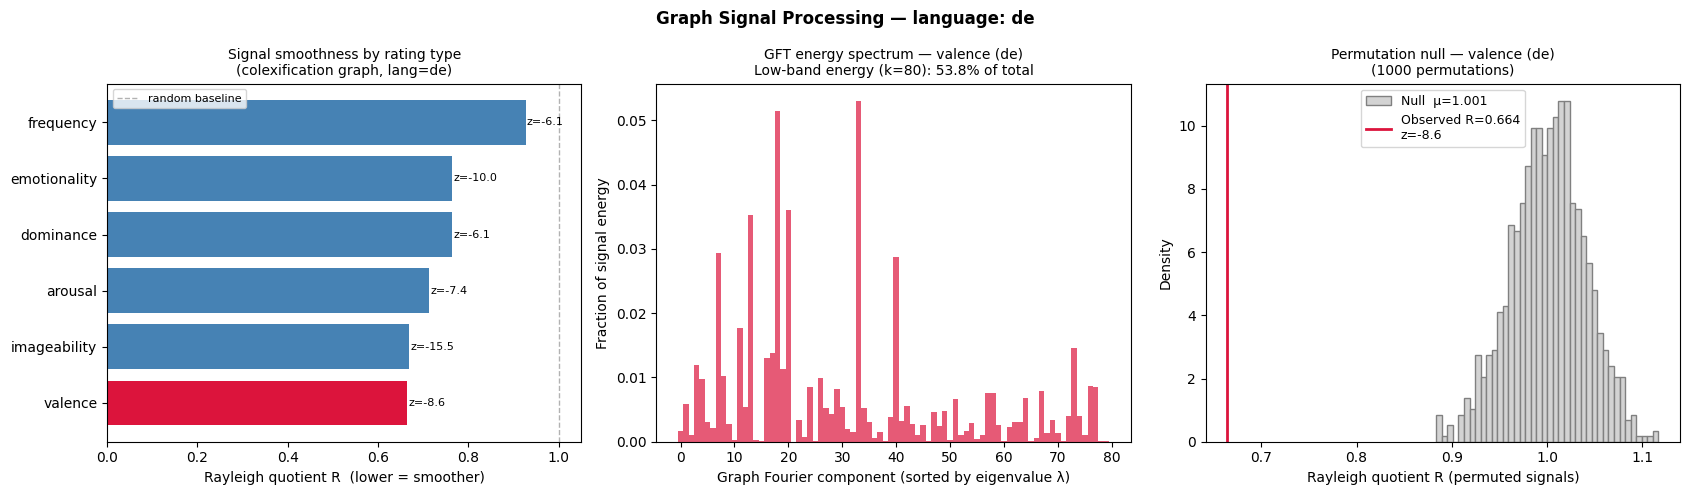

  → saved figures/gsp/gsp_de.pdf

── en ──────────────────────────────────────────
  valence          R=0.5978  z= -40.31  p=0.0000  n=2841
  arousal          R=0.6288  z= -37.49  p=0.0000  n=2841
  dominance        R=0.5934  z= -40.48  p=0.0000  n=2710
  AoA              R=0.9265  z=  -6.15  p=0.0000  n=2811
  imageability     R=0.6712  z= -28.91  p=0.0000  n=2094
  familiarity      R=0.9038  z=  -9.01  p=0.0000  n=2988
  frequency        R=0.6319  z= -34.90  p=0.0000  n=2877
  concreteness     R=0.5102  z= -48.83  p=0.0000  n=2720


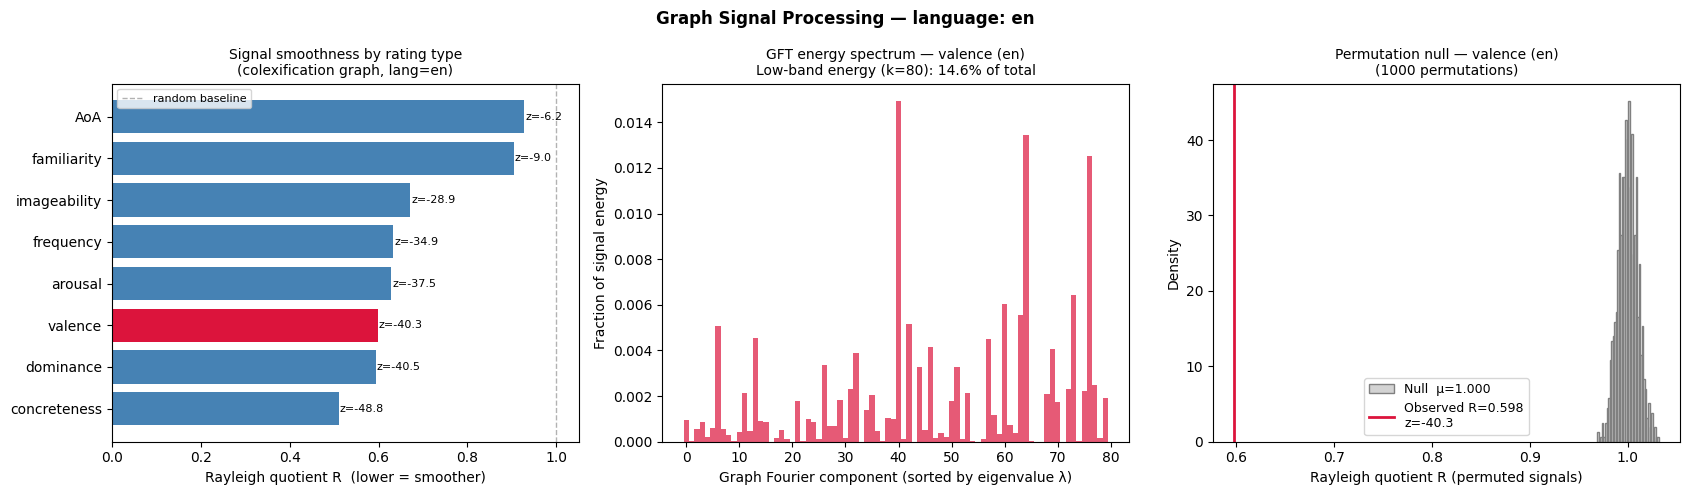

  → saved figures/gsp/gsp_en.pdf

── es ──────────────────────────────────────────
  valence          R=0.7258  z= -17.82  p=0.0000  n=1393
  arousal          R=0.7760  z= -15.13  p=0.0000  n=1393
  dominance        R=0.6915  z=  -8.14  p=0.0000  n=347
  AoA              R=0.9242  z=  -4.81  p=0.0000  n=1424
  imageability     R=0.6736  z=  -8.80  p=0.0000  n=332
  frequency        R=0.9391  z=  -4.03  p=0.0070  n=1580
  concreteness     R=0.7551  z=  -6.34  p=0.0000  n=332


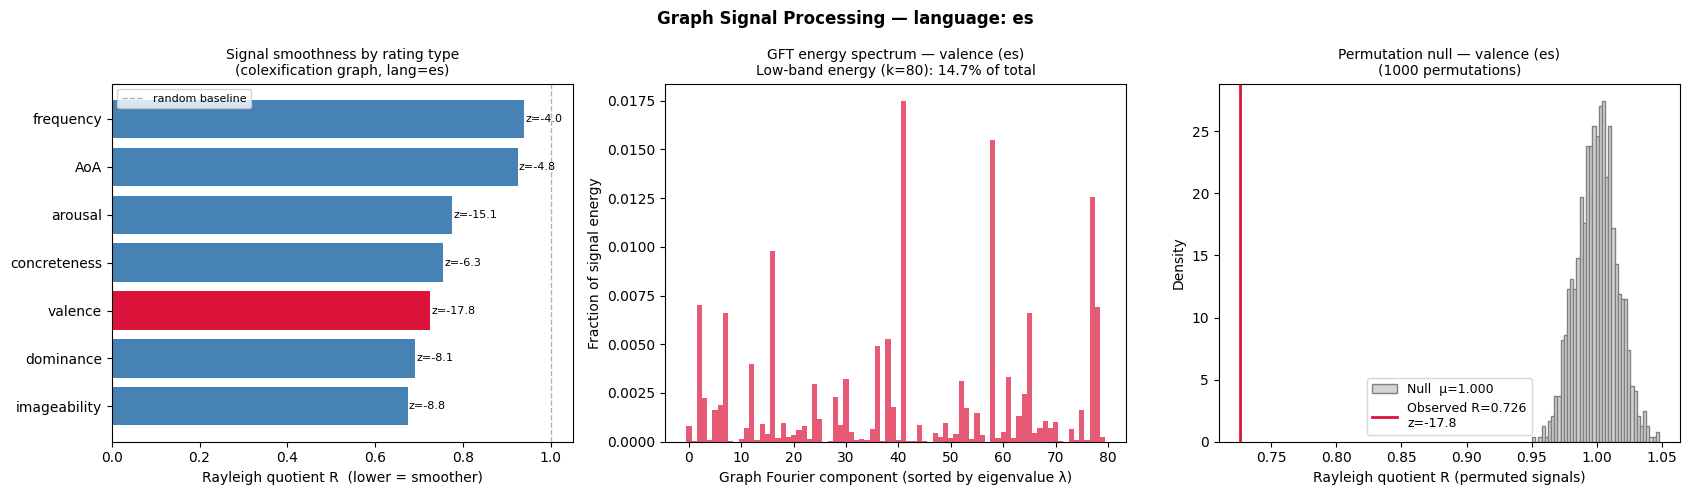

  → saved figures/gsp/gsp_es.pdf

── fr ──────────────────────────────────────────
  valence          R=0.8337  z=  -7.11  p=0.0000  n=707
  arousal          R=0.8194  z=  -7.53  p=0.0000  n=706
  imageability     R=0.7542  z=  -9.11  p=0.0000  n=678
  familiarity      R=0.9690  z=  -1.27  p=0.1160  n=675
  frequency        R=0.8146  z=  -7.01  p=0.0000  n=678
  concreteness     R=0.6293  z= -15.37  p=0.0000  n=707


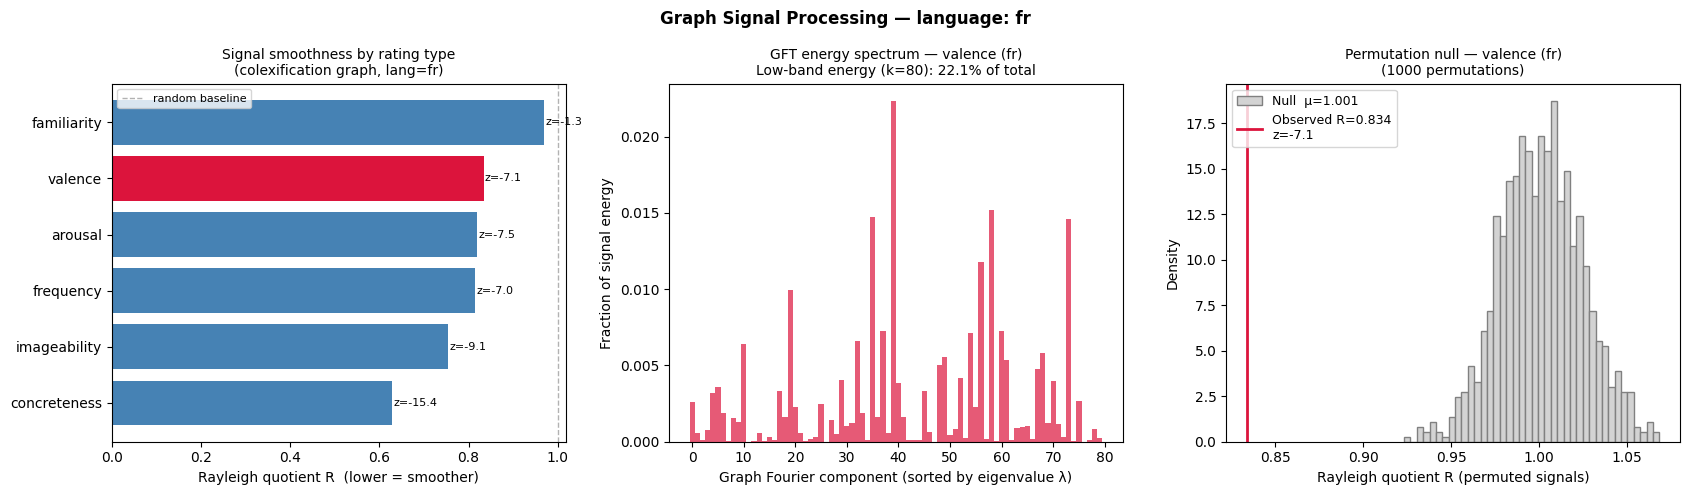

  → saved figures/gsp/gsp_fr.pdf

── it ──────────────────────────────────────────
  valence          R=0.5714  z= -15.00  p=0.0000  n=607
  arousal          R=0.6814  z= -11.83  p=0.0000  n=607
  dominance        R=0.6621  z= -12.23  p=0.0000  n=607
  AoA              R=0.9238  z=  -3.77  p=0.0000  n=997
  imageability     R=0.6302  z= -13.09  p=0.0000  n=607
  familiarity      R=0.7808  z=  -8.09  p=0.0000  n=607
  frequency        R=0.8888  z=  -7.32  p=0.0040  n=1081
  concreteness     R=0.5110  z= -17.73  p=0.0000  n=607


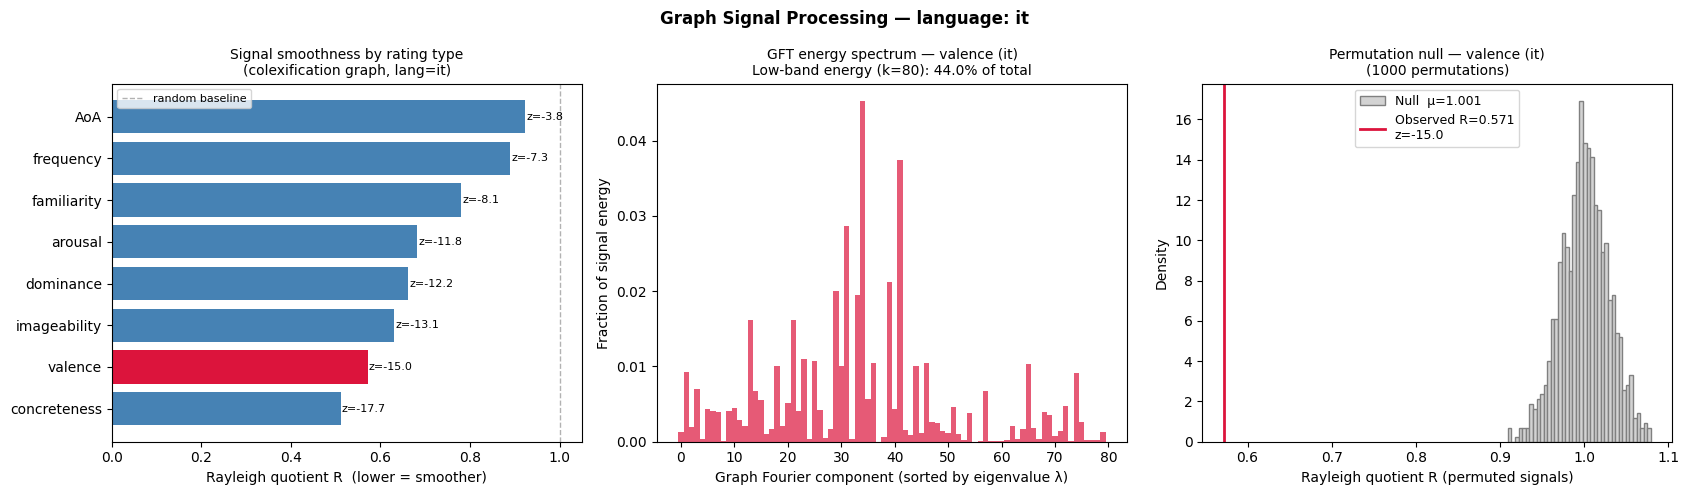

  → saved figures/gsp/gsp_it.pdf

── nl ──────────────────────────────────────────
  valence          R=0.6691  z= -14.91  p=0.0000  n=777
  arousal          R=0.6689  z= -14.51  p=0.0000  n=777
  AoA              R=0.9242  z=  -3.35  p=0.0000  n=794
  familiarity      R=0.9905  z=  -0.39  p=0.2570  n=802
  frequency        R=0.4621  z= -44.64  p=0.0000  n=802
  concreteness     R=0.5564  z= -19.82  p=0.0000  n=794


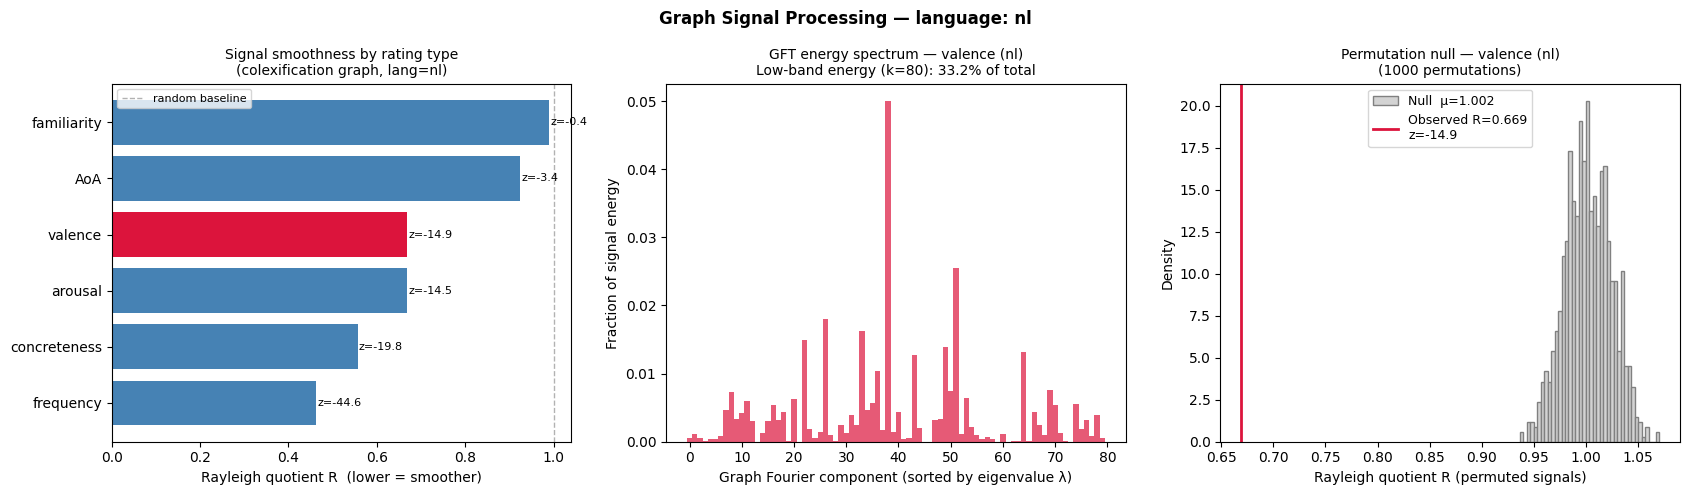

  → saved figures/gsp/gsp_nl.pdf

── pl ──────────────────────────────────────────
  valence          R=0.6973  z= -14.65  p=0.0000  n=842
  arousal          R=0.7072  z= -14.20  p=0.0000  n=842
  dominance        R=0.6778  z= -14.60  p=0.0000  n=754
  AoA              R=0.9583  z=  -1.85  p=0.0360  n=754
  imageability     R=0.6631  z= -16.27  p=0.0000  n=842
  frequency        R=0.9210  z=  -6.63  p=0.0030  n=1055
  concreteness     R=0.5279  z= -21.02  p=0.0000  n=754


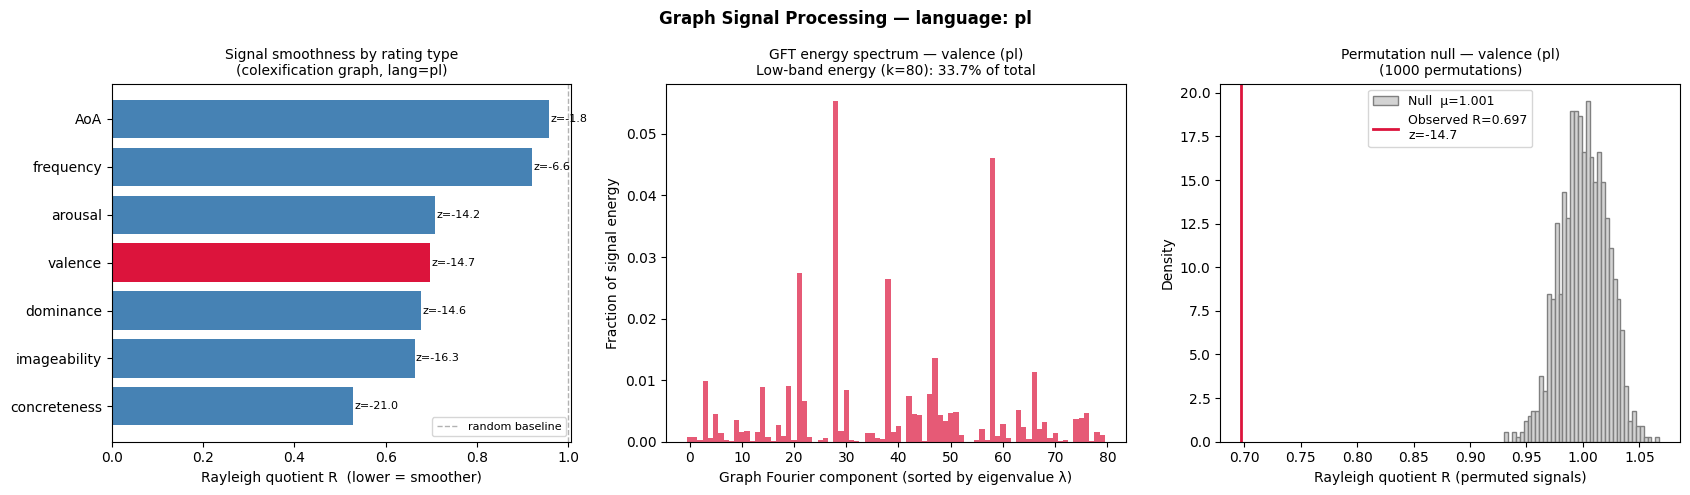

  → saved figures/gsp/gsp_pl.pdf

── pt ──────────────────────────────────────────
  valence          R=0.7147  z=  -6.12  p=0.0000  n=222
  arousal          R=0.7149  z=  -6.10  p=0.0000  n=222
  dominance        R=0.7520  z=  -5.07  p=0.0000  n=222
  AoA              R=0.9019  z=  -2.13  p=0.0180  n=228
  familiarity      R=0.6495  z=  -2.94  p=0.0050  n=45


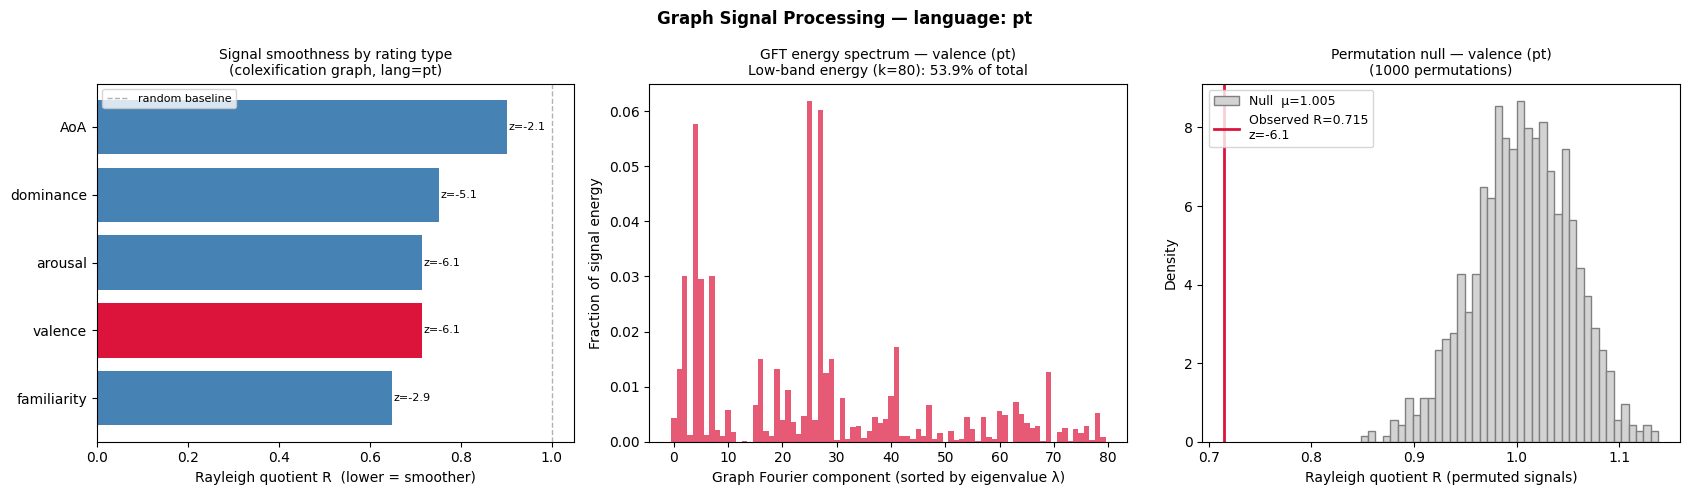

  → saved figures/gsp/gsp_pt.pdf

── tr ──────────────────────────────────────────
  valence          R=0.8009  z=  -4.49  p=0.0000  n=264
  arousal          R=0.8225  z=  -4.08  p=0.0000  n=264
  concreteness     R=0.6121  z=  -8.67  p=0.0000  n=264


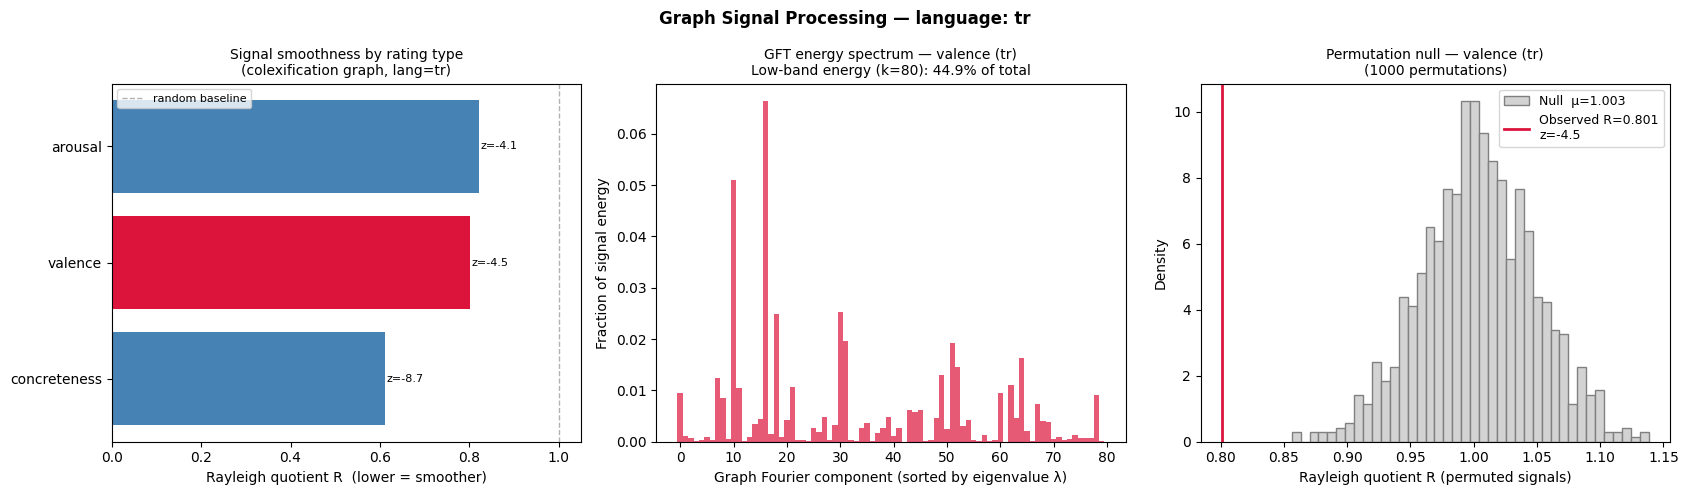

  → saved figures/gsp/gsp_tr.pdf

── zh ──────────────────────────────────────────
  valence          R=0.7382  z= -13.37  p=0.0000  n=973
  arousal          R=0.8193  z=  -9.05  p=0.0000  n=973
  AoA              R=0.8920  z=  -4.31  p=0.0000  n=653
  imageability     R=0.7094  z= -17.35  p=0.0000  n=1154
  familiarity      R=0.9537  z=  -1.95  p=0.0280  n=734
  frequency        R=0.8518  z= -12.93  p=0.0000  n=1901
  concreteness     R=0.8693  z=  -8.44  p=0.0000  n=1394


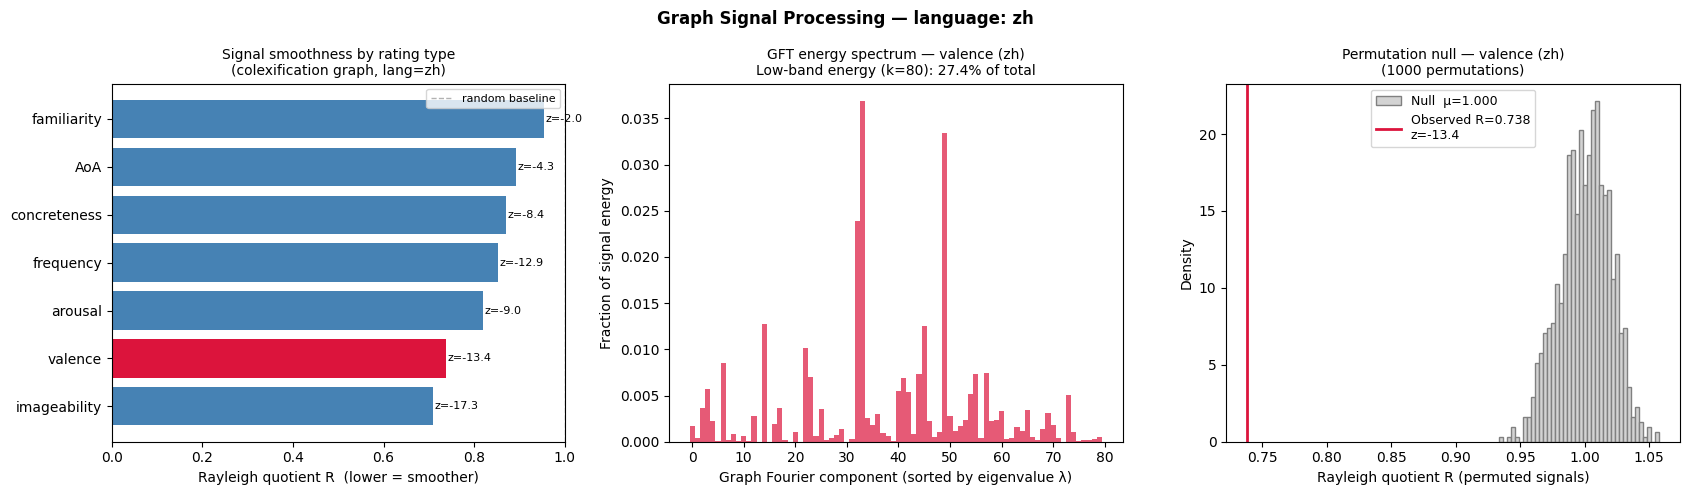

  → saved figures/gsp/gsp_zh.pdf

Summary CSV saved → figures/gsp/rayleigh_all_languages.csv
lang             de     en     es     fr     it     nl     pl     pt     tr     zh
rating_type                                                                       
AoA             NaN  0.926  0.924    NaN  0.924  0.924  0.958  0.902    NaN  0.892
arousal       0.713  0.629  0.776  0.819  0.681  0.669  0.707  0.715  0.822  0.819
concreteness    NaN  0.510  0.755  0.629  0.511  0.556  0.528    NaN  0.612  0.869
dominance     0.763  0.593  0.692    NaN  0.662    NaN  0.678  0.752    NaN    NaN
emotionality  0.764    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
familiarity     NaN  0.904    NaN  0.969  0.781  0.990    NaN  0.650    NaN  0.954
frequency     0.927  0.632  0.939  0.815  0.889  0.462  0.921    NaN    NaN  0.852
imageability  0.668  0.671  0.674  0.754  0.630    NaN  0.663    NaN    NaN  0.709
valence       0.664  0.598  0.726  0.834  0.571  0.669  0.697  0.715  0.801  

In [19]:
import os

OUT_DIR = Path("figures/gsp")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ── Rayleigh quotient across all rating types × all languages ───────────────
# For each language, only include rating types that have ratings in that language.

all_results = []   # rows for summary CSV

for lang in sorted(LANGS_V):
    print(f"\n── {lang} ──────────────────────────────────────────")
    rt_gsp_lang = {}

    for rt in RATING_TYPES:
        if rt not in INDEX:
            continue
        if lang not in INDEX[rt]["rated_langs"]:
            continue
        g_rt = load_merged(rt)
        A, rated, x = build_adjacency(g_rt, lang)
        if len(rated) < 30:
            continue
        L = normalized_laplacian(A)
        obs, nulls, z, p = permutation_test(L, x, n_perm=1000)
        rt_gsp_lang[rt] = {"R": obs, "z": z, "p": p, "n": len(rated),
                           "rand_mean": nulls.mean(), "rand_std": nulls.std(),
                           "nulls": nulls}
        all_results.append({"lang": lang, "rating_type": rt,
                             "R": round(obs, 4), "z": round(z, 2),
                             "p": round(p, 4), "n_concepts": len(rated),
                             "rand_mean": round(nulls.mean(), 4)})
        print(f"  {rt:<16} R={obs:.4f}  z={z:>7.2f}  p={p:.4f}  n={len(rated)}")

    if not rt_gsp_lang:
        continue

    # GFT for valence in this language
    A_l, rated_l, x_l = build_adjacency(GV, lang)
    L_l = normalized_laplacian(A_l)
    k_gft = min(80, len(rated_l) - 2)
    low_frac, eig_vals, gft_coeffs = gft_low_band_energy(L_l, x_l, k=k_gft)

    # ── Figure: 3 panels ────────────────────────────────────────────────────
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))
    fig.suptitle(f"Graph Signal Processing — language: {lang}", fontsize=12, fontweight="bold")

    # Panel 1: Rayleigh by rating type
    ax = axes[0]
    types_sorted = sorted(rt_gsp_lang, key=lambda t: rt_gsp_lang[t]["R"])
    r_vals = [rt_gsp_lang[t]["R"] for t in types_sorted]
    z_vals = [rt_gsp_lang[t]["z"] for t in types_sorted]
    cols   = ["crimson" if t == "valence" else "steelblue" for t in types_sorted]
    ax.barh(types_sorted, r_vals, color=cols)
    for i, t in enumerate(types_sorted):
        ax.text(r_vals[i] + 0.003, i, f"z={z_vals[i]:.1f}", va="center", fontsize=8)
    ax.set_xlabel("Rayleigh quotient R  (lower = smoother)", fontsize=10)
    ax.set_title(f"Signal smoothness by rating type\n(colexification graph, lang={lang})", fontsize=10)
    ax.axvline(1.0, color="gray", lw=1, linestyle="--", alpha=0.6, label="random baseline")
    ax.legend(fontsize=8)

    # Panel 2: GFT energy spectrum for valence
    ax2 = axes[1]
    energy_per = gft_coeffs**2 / (float(np.dot(x_l, x_l)) + 1e-12)
    ax2.bar(range(len(eig_vals)), energy_per, width=1.0, color="crimson", alpha=0.7)
    ax2.set_xlabel("Graph Fourier component (sorted by eigenvalue λ)", fontsize=10)
    ax2.set_ylabel("Fraction of signal energy", fontsize=10)
    ax2.set_title(f"GFT energy spectrum — valence ({lang})\n"
                  f"Low-band energy (k={k_gft}): {low_frac:.1%} of total", fontsize=10)

    # Panel 3: permutation null distribution for valence
    ax3 = axes[2]
    val_entry = rt_gsp_lang.get("valence")
    if val_entry:
        nulls_v = val_entry["nulls"]
        ax3.hist(nulls_v, bins=40, color="lightgray", edgecolor="gray", density=True,
                 label=f"Null  μ={nulls_v.mean():.3f}")
        ax3.axvline(val_entry["R"], color="crimson", lw=2,
                    label=f"Observed R={val_entry['R']:.3f}\nz={val_entry['z']:.1f}")
        ax3.set_xlabel("Rayleigh quotient R (permuted signals)", fontsize=10)
        ax3.set_ylabel("Density", fontsize=10)
        ax3.set_title(f"Permutation null — valence ({lang})\n(1000 permutations)", fontsize=10)
        ax3.legend(fontsize=9)

    plt.tight_layout()
    fig_path = OUT_DIR / f"gsp_{lang}.pdf"
    plt.savefig(fig_path, bbox_inches="tight")
    plt.show()
    print(f"  → saved {fig_path}")

# ── Save summary CSV ────────────────────────────────────────────────────────
import csv as _csv

df_gsp = pd.DataFrame(all_results)[["lang","rating_type","R","z","p","n_concepts","rand_mean"]]
csv_path = OUT_DIR / "rayleigh_all_languages.csv"
df_gsp.to_csv(csv_path, index=False)
print(f"\nSummary CSV saved → {csv_path}")
print(df_gsp.pivot(index="rating_type", columns="lang", values="R").round(3).to_string())


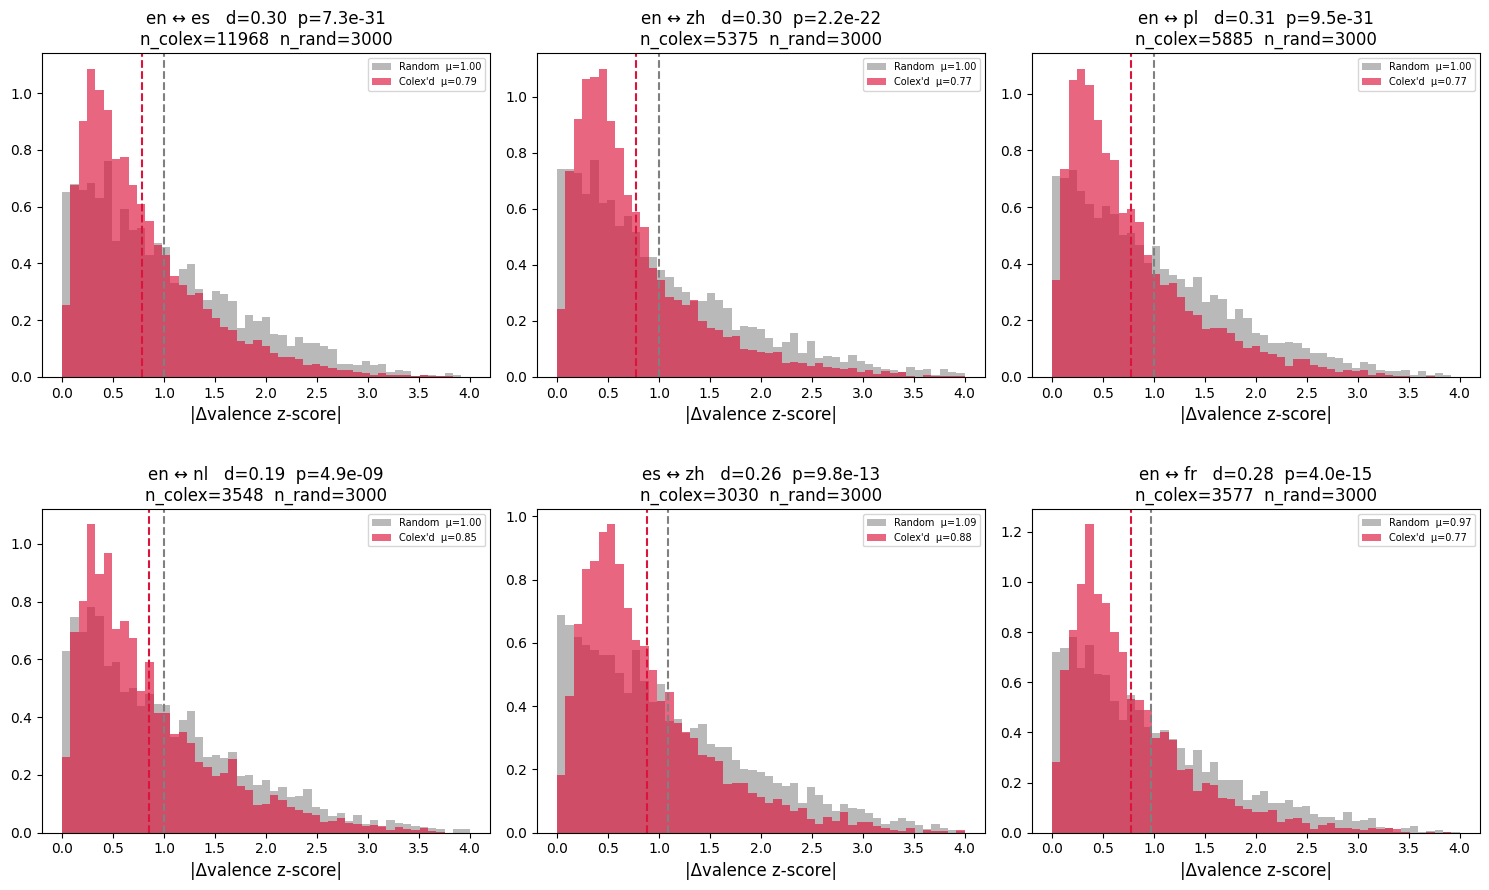

Summary:
  en↔es  colex μ=0.788  rand μ=0.997  Cohen d=0.299  p=7.30e-31
  en↔zh  colex μ=0.773  rand μ=1.000  Cohen d=0.303  p=2.18e-22
  en↔pl  colex μ=0.773  rand μ=0.996  Cohen d=0.314  p=9.51e-31
  en↔nl  colex μ=0.852  rand μ=0.995  Cohen d=0.193  p=4.90e-09
  es↔zh  colex μ=0.883  rand μ=1.086  Cohen d=0.264  p=9.79e-13
  en↔fr  colex μ=0.774  rand μ=0.967  Cohen d=0.276  p=3.96e-15


In [7]:
# For the most data-rich language pairs, compare:
#   A) |Δvalence_z| for colex'd pairs  vs.  B) random non-colex'd pairs
# Hypothesis: colex'd pairs should have SMALLER z-diff than random pairs.

FOCAL_PAIRS = [("en","es"), ("en","zh"), ("en","pl"), ("en","nl"), ("es","zh"), ("en","fr")]
FOCAL_PAIRS = [(a,b) for (a,b) in FOCAL_PAIRS if a in LANGS_V and b in LANGS_V]

N_SAMPLES = 3000
results_colex = {}
results_random = {}

for la, lb in FOCAL_PAIRS:
    colex_d, _, _ = edge_zdiff_series(GV, la, lb)
    rand_d        = random_pair_zdiff(GV, la, lb, n_samples=N_SAMPLES)
    results_colex[(la,lb)]  = colex_d
    results_random[(la,lb)] = rand_d

# Plot distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
axes = axes.flatten()

for ax, (la, lb) in zip(axes, FOCAL_PAIRS):
    cd = results_colex[(la,lb)]
    rd = results_random[(la,lb)]
    if len(cd)==0 or len(rd)==0: ax.axis("off"); continue

    # Cohen's d
    pooled_std = np.sqrt((cd.std()**2 + rd.std()**2) / 2)
    cohens_d   = (rd.mean() - cd.mean()) / (pooled_std + 1e-9)

    # Mann-Whitney U test
    u_stat, p_val = stats.mannwhitneyu(cd, rd, alternative="less")

    bins = np.linspace(0, min(4, max(cd.max(), rd.max())), 50)
    ax.hist(rd, bins=bins, alpha=0.55, color="gray",  label=f"Random  μ={rd.mean():.2f}", density=True)
    ax.hist(cd, bins=bins, alpha=0.65, color="crimson", label=f"Colex'd  μ={cd.mean():.2f}", density=True)
    ax.axvline(cd.mean(), color="crimson", lw=1.5, linestyle="--")
    ax.axvline(rd.mean(), color="gray",    lw=1.5, linestyle="--")
    ax.set_title(f"{la} ↔ {lb}   d={cohens_d:.2f}  p={p_val:.1e}\nn_colex={len(cd)}  n_rand={len(rd)}", fontsize=12)
    ax.set_xlabel("|Δvalence z-score|", fontsize=12)
    ax.legend(fontsize=7)

# fig.suptitle("Valence z-diff: Colexified Concept Pairs vs. Random Concept Pairs\n"
#              "Red = colex'd, Grey = random | d = Cohen's d (effect size), p = Mann-Whitney",
#              fontsize=11)
plt.tight_layout(h_pad=3.0)
plt.savefig("colex_valence_similarity.pdf")
plt.show()

print("Summary:")
for la, lb in FOCAL_PAIRS:
    cd = results_colex[(la,lb)]; rd = results_random[(la,lb)]
    if len(cd)==0: continue
    pooled = np.sqrt((cd.std()**2+rd.std()**2)/2)
    d = (rd.mean()-cd.mean())/(pooled+1e-9)
    _, p = stats.mannwhitneyu(cd, rd, alternative="less")
    print(f"  {la}↔{lb}  colex μ={cd.mean():.3f}  rand μ={rd.mean():.3f}  Cohen d={d:.3f}  p={p:.2e}")

## Part 3 — Valence similarity as a colexification predictor (ROC / AUC)

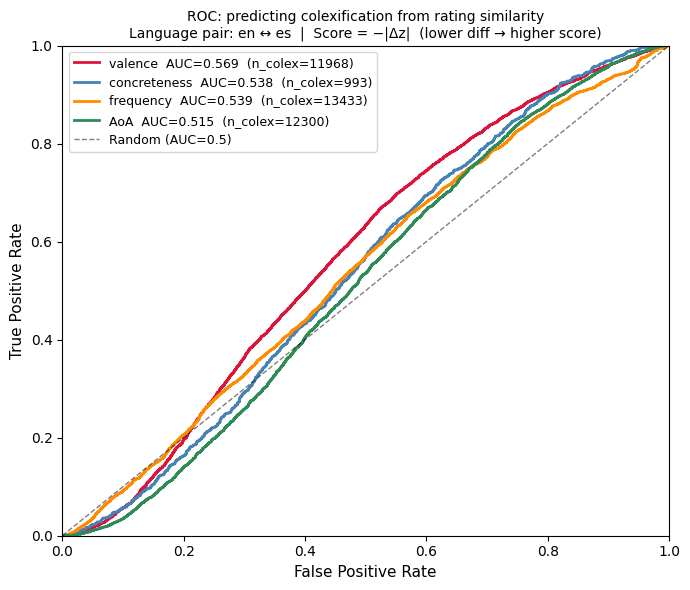

Valence AUC across language pairs:
  en↔es  AUC=0.565  n_colex=11968


  en↔zh  AUC=0.582  n_colex=5375
  en↔pl  AUC=0.563  n_colex=5885


  en↔nl  AUC=0.533  n_colex=3548
  es↔zh  AUC=0.544  n_colex=3030


In [5]:
# Build a binary dataset: for each concept pair (colex'd=1, random=0),
# compute valence z-diff. Train a simple threshold classifier and compute AUC.
# Also compare valence vs. AoA as predictors.

LA, LB = "en", "es"   # focal pair with good coverage

def build_predictor_dataset(g_rt, la, lb, n_rand=5000):
    """Build (features, label) for colex'd=1 vs random=0 pairs."""
    colex_pairs = {(min(e["source"],e["target"]), max(e["source"],e["target"]))
                   for e in g_rt["edges"]}
    rated = [cid for cid, n in g_rt["nodes"].items()
             if la in n["mean_z"] and lb in n["mean_z"]]
    cids = np.array(rated)

    records = []
    # Positive: colex'd
    for e in g_rt["edges"]:
        d = e["abs_z_diff_per_lang"]
        if la in d and lb in d:
            records.append({"zdiff": (d[la]+d[lb])/2, "label": 1,
                            "n_colex_langs": e["n_languages"]})
    # Negative: random
    added, tries = 0, 0
    while added < n_rand and tries < n_rand*20:
        i, j = np.random.choice(len(cids), 2, replace=False)
        a, b = cids[i], cids[j]
        pair = (min(a,b), max(a,b))
        if pair not in colex_pairs:
            za = g_rt["nodes"][a]["mean_z"][la]
            zb = g_rt["nodes"][b]["mean_z"][lb]
            records.append({"zdiff": abs(za-zb), "label": 0, "n_colex_langs": 0})
            added += 1
        tries += 1
    return pd.DataFrame(records)

# Valence predictor
df_val = build_predictor_dataset(GV, LA, LB)
# AoA predictor  
g_aoa = load_merged("AoA")
df_aoa = build_predictor_dataset(g_aoa, LA, LB)
# Concreteness predictor
g_con = load_merged("concreteness")
df_con = build_predictor_dataset(g_con, LA, LB)
# Frequency predictor
g_frq = load_merged("frequency")
df_frq = build_predictor_dataset(g_frq, LA, LB)

def compute_roc(df):
    # Higher z-diff → LESS likely to be colex'd → use -zdiff as score
    score = -df["zdiff"].values
    label = df["label"].values
    auc = roc_auc_score(label, score)
    fpr, tpr, _ = roc_curve(label, score)
    return fpr, tpr, auc

fig, ax = plt.subplots(figsize=(7, 6))
for df, label, color in [
    (df_val, "valence",      "crimson"),
    (df_con, "concreteness", "steelblue"),
    (df_frq, "frequency",    "darkorange"),
    (df_aoa, "AoA",          "seagreen"),
]:
    fpr, tpr, auc = compute_roc(df)
    n_pos = df["label"].sum()
    ax.plot(fpr, tpr, lw=2, color=color, label=f"{label}  AUC={auc:.3f}  (n_colex={n_pos})")

ax.plot([0,1],[0,1],"k--", lw=1, alpha=0.5, label="Random (AUC=0.5)")
ax.set_xlabel("False Positive Rate", fontsize=11)
ax.set_ylabel("True Positive Rate", fontsize=11)
ax.set_title(f"ROC: predicting colexification from rating similarity\n"
             f"Language pair: {LA} ↔ {LB}  |  Score = −|Δz|  (lower diff → higher score)",
             fontsize=10)
ax.legend(fontsize=9); ax.set_xlim(0,1); ax.set_ylim(0,1)
plt.tight_layout(); plt.show()

# Show AUC across multiple language pairs for valence
print("Valence AUC across language pairs:")
for la2, lb2 in [("en","es"),("en","zh"),("en","pl"),("en","nl"),("es","zh")]:
    if la2 not in LANGS_V or lb2 not in LANGS_V: continue
    df = build_predictor_dataset(GV, la2, lb2, n_rand=2000)
    _, _, auc = compute_roc(df)
    n_pos = int(df["label"].sum())
    print(f"  {la2}↔{lb2}  AUC={auc:.3f}  n_colex={n_pos}")


## Part 4 — Universal vs. culture-specific colexifications

Edges rated in ≥3 languages: 9382

--- TOP 20 MOST UNIVERSAL COLEX PAIRS (lowest valence z-diff) ---
    source           target  mean_zdiff  std_zdiff  n_rated_langs                                                                                    colex_langs  src_valence  tgt_valence
    FINGER           BRANCH    0.016477   0.022266              3                                                                                             GD       -0.005        0.026
     PIECE STATE (POLITICS)    0.031942   0.036577              3                                                                                             GA        0.022       -0.146
 YOUNG MAN            HONEY    0.032440   0.005286              3                                                                                 DA, ID, NL, NO        0.712        0.881
     THING STATE (POLITICS)    0.038744   0.027235              3                                                                                      

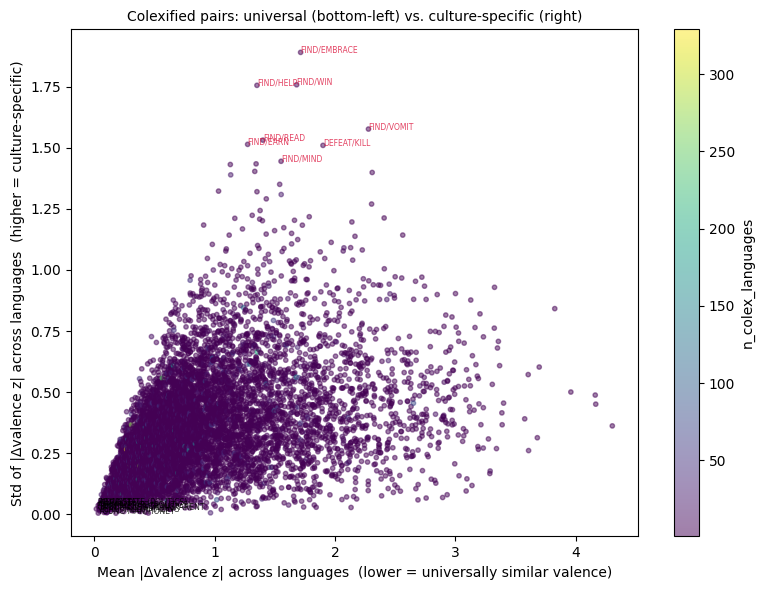

In [6]:
# For each colex'd edge rated in ≥3 languages, compute:
#   mean_zdiff  = average |Δvalence| across rated languages  (lower = more universal)
#   std_zdiff   = std of |Δvalence| across rated languages   (lower = more consistent)
# Universal pairs: low mean AND low std
# Culture-specific: high std (languages disagree on valence similarity)

records = []
for e in GV["edges"]:
    d = e["abs_z_diff_per_lang"]
    if len(d) < 3: continue
    diffs = list(d.values())
    src_gloss = GV["nodes"][e["source"]]["gloss"]
    tgt_gloss = GV["nodes"][e["target"]]["gloss"]
    src_z_mean = np.mean(list(e["source_z"].values()))
    tgt_z_mean = np.mean(list(e["target_z"].values()))
    records.append({
        "source": src_gloss, "target": tgt_gloss,
        "src_id": e["source"], "tgt_id": e["target"],
        "mean_zdiff":  np.mean(diffs),
        "std_zdiff":   np.std(diffs),
        "n_rated_langs": len(d),
        "n_colex_langs": e["n_languages"],
        "colex_langs":   ", ".join(sorted(e["colex_languages"])),
        "src_valence":   round(src_z_mean, 3),
        "tgt_valence":   round(tgt_z_mean, 3),
        "langs_rated":   ", ".join(sorted(d.keys())),
    })

df_pairs = pd.DataFrame(records).sort_values("mean_zdiff")
print(f"Edges rated in ≥3 languages: {len(df_pairs)}")

# Universal: lowest mean_zdiff (colex'd AND similar valence in all languages)
print("\n--- TOP 20 MOST UNIVERSAL COLEX PAIRS (lowest valence z-diff) ---")
cols = ["source","target","mean_zdiff","std_zdiff","n_rated_langs","colex_langs","src_valence","tgt_valence"]
print(df_pairs.head(20)[cols].to_string(index=False))

print("\n--- TOP 20 MOST CULTURE-SPECIFIC COLEX PAIRS (highest std_zdiff) ---")
print(df_pairs.nlargest(20,"std_zdiff")[cols].to_string(index=False))

# Scatter: mean_zdiff vs std_zdiff
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(df_pairs["mean_zdiff"], df_pairs["std_zdiff"],
                c=df_pairs["n_colex_langs"], cmap="viridis", s=10, alpha=0.5)
# Label universals
for _, row in df_pairs.head(8).iterrows():
    ax.annotate(f"{row['source']}/{row['target']}", (row["mean_zdiff"], row["std_zdiff"]),
                fontsize=5.5, alpha=0.8)
# Label culture-specific
for _, row in df_pairs.nlargest(8,"std_zdiff").iterrows():
    ax.annotate(f"{row['source']}/{row['target']}", (row["mean_zdiff"], row["std_zdiff"]),
                fontsize=5.5, color="crimson", alpha=0.8)
fig.colorbar(sc, ax=ax, label="n_colex_languages")
ax.set_xlabel("Mean |Δvalence z| across languages  (lower = universally similar valence)", fontsize=10)
ax.set_ylabel("Std of |Δvalence z| across languages  (higher = culture-specific)", fontsize=10)
ax.set_title("Colexified pairs: universal (bottom-left) vs. culture-specific (right)", fontsize=10)
plt.tight_layout(); plt.show()


## Part 5 — Language family effects on valence agreement

Within-family  pairs: n=9  mean r = 0.899  ± 0.037
Cross-family   pairs: n=36  mean r = 0.845  ± 0.058
t-test: t=2.66  p=0.0109

la lb        r    n  family_match              families
es pt 0.945808  197          True       Romance–Romance
pl pt 0.937202  133         False        Slavic–Romance
it pt 0.931647  188          True       Romance–Romance
de nl 0.927549  161          True     Germanic–Germanic
de pl 0.926652  200         False       Germanic–Slavic
de pt 0.919928  156         False      Germanic–Romance
it pl 0.916470  314         False        Romance–Slavic
nl pt 0.913930  107         False      Germanic–Romance
fr pt 0.913256  110          True       Romance–Romance
es it 0.912450  418          True       Romance–Romance
de es 0.911259  268         False      Germanic–Romance
en pt 0.910040  219         False      Germanic–Romance
de it 0.906444  266         False      Germanic–Romance
de fr 0.903269  163         False      Germanic–Romance
de en 0.901671  313          Tr

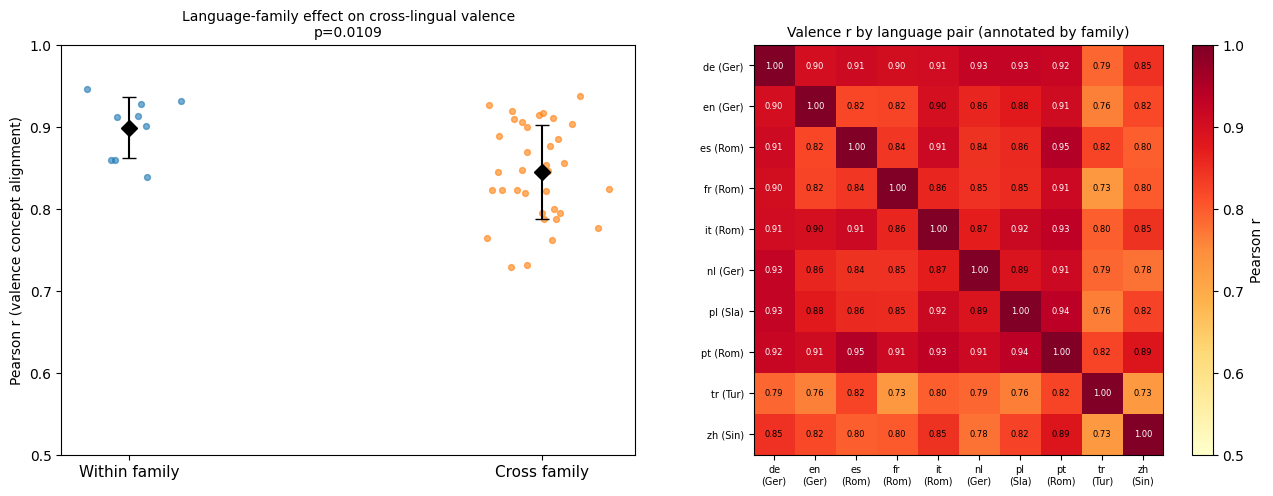

In [7]:
# Test whether within-family language pairs show stronger valence alignment
# than cross-family pairs for colexified concepts.

family_pairs = []   # (la, lb, family_match, r)
for i, la in enumerate(LANGS_V):
    for lb in LANGS_V[i+1:]:
        r, n = lang_pair_r(GV, la, lb)
        if np.isnan(r) or n < 50: continue
        fa = LANG_FAMILIES.get(la, "Other")
        fb = LANG_FAMILIES.get(lb, "Other")
        family_pairs.append({
            "la": la, "lb": lb, "r": r, "n": n,
            "family_match": fa == fb,
            "families": f"{fa}–{fb}",
        })

df_fam = pd.DataFrame(family_pairs)
within  = df_fam[df_fam["family_match"]]["r"]
across  = df_fam[~df_fam["family_match"]]["r"]
t, p = stats.ttest_ind(within, across)

print(f"Within-family  pairs: n={len(within)}  mean r = {within.mean():.3f}  ± {within.std():.3f}")
print(f"Cross-family   pairs: n={len(across)}  mean r = {across.mean():.3f}  ± {across.std():.3f}")
print(f"t-test: t={t:.2f}  p={p:.4f}")
print()
print(df_fam.sort_values("r", ascending=False).to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: strip plot
ax = axes[0]
for i, (label, grp) in enumerate([("Within family", within), ("Cross family", across)]):
    x = np.random.normal(i, 0.07, len(grp))
    ax.scatter(x, grp, s=18, alpha=0.6)
    ax.errorbar(i, grp.mean(), yerr=grp.std(), fmt="D", color="black", ms=8, capsize=5, zorder=5)
ax.set_xticks([0,1]); ax.set_xticklabels(["Within family","Cross family"], fontsize=11)
ax.set_ylabel("Pearson r (valence concept alignment)", fontsize=10)
ax.set_title(f"Language-family effect on cross-lingual valence\np={p:.4f}", fontsize=10)
ax.set_ylim(0.5, 1.0)

# Right: r heatmap annotated by family
ax2 = axes[1]
n_l = len(LANGS_V)
R_mat = np.full((n_l,n_l), np.nan)
for i, la in enumerate(LANGS_V):
    R_mat[i,i] = 1.0
    for j, lb in enumerate(LANGS_V):
        if i<j:
            r = next((row["r"] for _, row in df_fam.iterrows()
                      if (row["la"]==la and row["lb"]==lb) or
                         (row["la"]==lb and row["lb"]==la)), float("nan"))
            R_mat[i,j] = R_mat[j,i] = r
families_sorted = [LANG_FAMILIES.get(l,"?") for l in LANGS_V]
im = ax2.imshow(R_mat, vmin=0.5, vmax=1.0, cmap="YlOrRd")
ax2.set_xticks(range(n_l))
ax2.set_xticklabels([f"{l}\n({LANG_FAMILIES.get(l,'?')[:3]})" for l in LANGS_V], fontsize=7)
ax2.set_yticks(range(n_l))
ax2.set_yticklabels([f"{l} ({LANG_FAMILIES.get(l,'?')[:3]})" for l in LANGS_V], fontsize=7)
for i in range(n_l):
    for j in range(n_l):
        if not np.isnan(R_mat[i,j]):
            ax2.text(j,i,f"{R_mat[i,j]:.2f}",ha="center",va="center",fontsize=10,
                     color="white" if R_mat[i,j]>0.9 else "black")
fig.colorbar(im, ax=ax2, label="Pearson r")
ax2.set_title("Valence r by language pair (annotated by family)", fontsize=10)

plt.tight_layout(); plt.show()


## Part 6 — Does colexifying *in* the same language as the rating strengthen valence alignment?

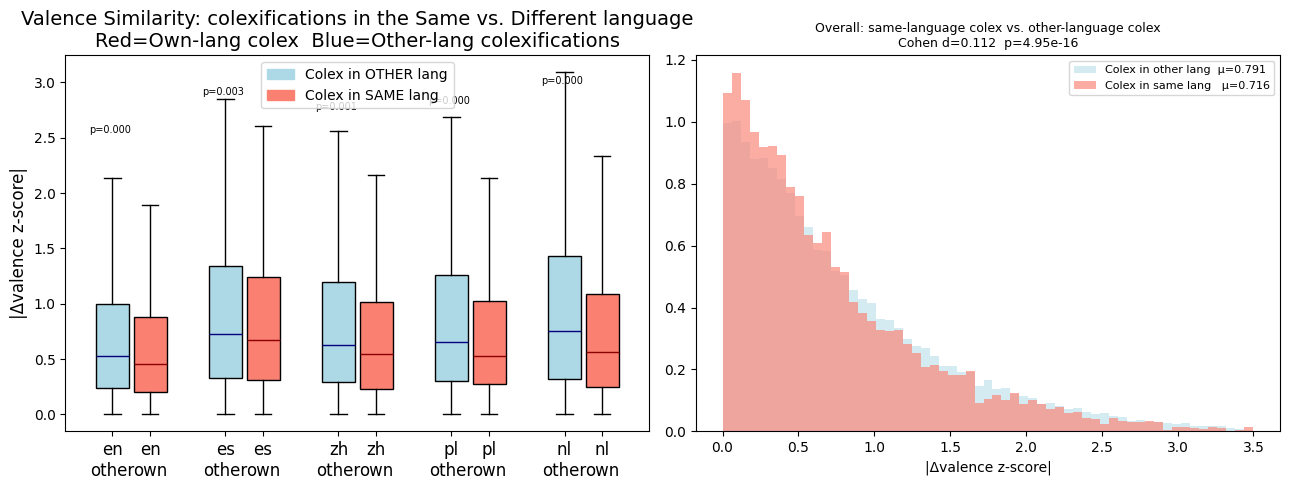


Effect: colex in same lang → smaller valence z-diff by 0.075 z-units


In [18]:
# Two concepts that are colexified specifically in Spanish and ALSO rated in Spanish
# should show the most similar Spanish valence, compared to pairs colex'd in other languages.
# This tests a directional prediction: the language in which concepts merge
# is the language where they are most cognitively similar.

FOCAL_LANGS = ["en", "es", "zh", "pl", "nl"]
# BabelNet uppercase codes
BABEL_MAP = {l: l.upper() for l in FOCAL_LANGS}

records = []
for e in GV["edges"]:
    colex_langs_babel = set(e["colex_languages"])     # BabelNet uppercase
    rated_langs = set(e["langs_rated_both"])           # norare lowercase

    for lang in FOCAL_LANGS:
        babel = BABEL_MAP[lang]
        zdiff = e["abs_z_diff_per_lang"].get(lang)
        if zdiff is None: continue
        colex_in_this_lang = babel in colex_langs_babel
        records.append({
            "lang": lang,
            "zdiff": zdiff,
            "colex_in_this_lang": colex_in_this_lang,
            "n_colex_langs": e["n_languages"],
        })

df_match = pd.DataFrame(records)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: box per language, split by colex_in_this_lang
ax = axes[0]
positions = []
labels = []
pos = 0
for lang in FOCAL_LANGS:
    sub = df_match[df_match["lang"]==lang]
    match = sub[sub["colex_in_this_lang"]]["zdiff"]
    nomatch = sub[~sub["colex_in_this_lang"]]["zdiff"]
    if len(match)<5 or len(nomatch)<5: continue
    bp1 = ax.boxplot(nomatch, positions=[pos],   widths=0.35, patch_artist=True,
                     boxprops=dict(facecolor="lightblue"), medianprops=dict(color="navy"), showfliers=False)
    bp2 = ax.boxplot(match,   positions=[pos+0.4], widths=0.35, patch_artist=True,
                     boxprops=dict(facecolor="salmon"), medianprops=dict(color="darkred"), showfliers=False)
    t, p = stats.mannwhitneyu(match, nomatch, alternative="less")
    ax.text(pos+0.2, max(nomatch.quantile(0.75), match.quantile(0.75))+1.55,
            f"p={p:.3f}", ha="right", fontsize=7)
    labels += [f"{lang}\nother", f"{lang}\nown"]
    positions += [pos, pos+0.4]
    pos += 1.2

ax.set_xticks(positions); ax.set_xticklabels(labels, fontsize=12)
from matplotlib.patches import Patch
ax.legend(handles=[Patch(color="lightblue",label="Colex in OTHER lang"),
                   Patch(color="salmon",    label="Colex in SAME lang")], fontsize=10)
ax.set_ylabel("|Δvalence z-score|", fontsize=12)
ax.set_title("Valence Similarity: colexifications in the Same vs. Different language\nRed=Own-lang colex  Blue=Other-lang colexifications", fontsize=14)

# Right: overall effect
ax2 = axes[1]
match_all   = df_match[df_match["colex_in_this_lang"]]["zdiff"]
nomatch_all = df_match[~df_match["colex_in_this_lang"]]["zdiff"]
t, p = stats.mannwhitneyu(match_all, nomatch_all, alternative="less")
pooled = np.sqrt((match_all.std()**2 + nomatch_all.std()**2)/2)
d = (nomatch_all.mean() - match_all.mean()) / pooled

bins = np.linspace(0, 3.5, 60)
ax2.hist(nomatch_all, bins=bins, density=True, alpha=0.5, color="lightblue",
         label=f"Colex in other lang  μ={nomatch_all.mean():.3f}")
ax2.hist(match_all,   bins=bins, density=True, alpha=0.65, color="salmon",
         label=f"Colex in same lang   μ={match_all.mean():.3f}")
ax2.set_xlabel("|Δvalence z-score|", fontsize=10)
ax2.set_title(f"Overall: same-language colex vs. other-language colex\nCohen d={d:.3f}  p={p:.2e}", fontsize=9)
ax2.legend(fontsize=8)

plt.tight_layout(); plt.show()
print(f"\nEffect: colex in same lang → smaller valence z-diff by {(nomatch_all.mean()-match_all.mean()):.3f} z-units")


## Part 7 — Valence polarity: do positive, neutral, or negative concepts colexify more?

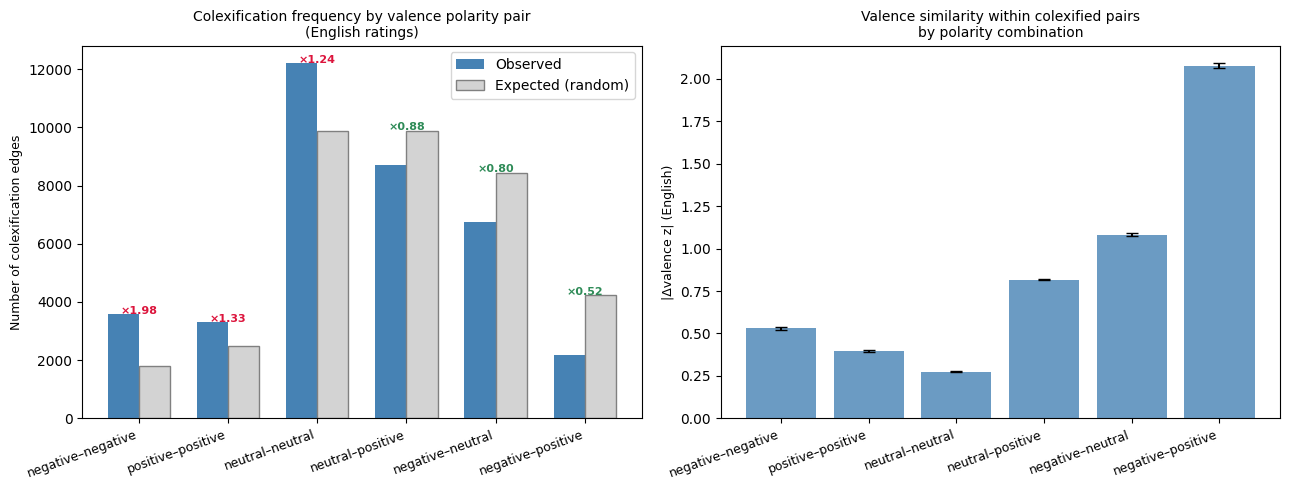


Observed / Expected ratio (>1 = over-represented colexification pattern):
negative–negative    1.985
positive–positive    1.333
neutral–neutral      1.236
neutral–positive     0.879
negative–neutral     0.800
negative–positive    0.516

Same polarity:  19094 edges (52.0%)
Cross polarity: 17635 edges (48.0%)


In [9]:
# Classify each concept by its English valence z-score into thirds:
# negative (z < -0.5), neutral (-0.5 ≤ z ≤ 0.5), positive (z > 0.5)
# Then ask: which polarity tier produces the most colexifications?
# And: do same-polarity colex pairs dominate?

def valence_tier(z):
    if z < -0.5:  return "negative"
    if z >  0.5:  return "positive"
    return "neutral"

# Per-concept polarity
concept_tier = {}
for cid, node in GV["nodes"].items():
    z = node["mean_z"].get("en")
    if z is not None:
        concept_tier[cid] = valence_tier(z)

# Colex edge: classify by (src_tier, tgt_tier)
pair_types = []
for e in GV["edges"]:
    t1 = concept_tier.get(e["source"])
    t2 = concept_tier.get(e["target"])
    if t1 and t2:
        pair = tuple(sorted([t1, t2]))
        zdiff = e["abs_z_diff_per_lang"].get("en")
        pair_types.append({"pair_type": f"{pair[0]}–{pair[1]}",
                           "same_polarity": t1==t2,
                           "zdiff_en": zdiff,
                           "n_colex_langs": e["n_languages"]})

df_pol = pd.DataFrame(pair_types)

# Expected frequency under random pairing
tier_counts = pd.Series(concept_tier).value_counts()
total = tier_counts.sum()
from itertools import combinations_with_replacement as cwr
expected = {}
for t1, t2 in cwr(["negative","neutral","positive"], 2):
    p = tier_counts.get(t1,0)*tier_counts.get(t2,0)/total**2
    if t1!=t2: p*=2
    expected[f"{t1}–{t2}"] = p

observed_counts = df_pol["pair_type"].value_counts()
expected_counts = pd.Series({k: v*len(df_pol) for k,v in expected.items()})
ratio = (observed_counts / expected_counts).dropna().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: observed vs expected
ax = axes[0]
pair_order = ratio.index
obs_vals = [observed_counts.get(p,0) for p in pair_order]
exp_vals = [expected_counts.get(p,0) for p in pair_order]
x = np.arange(len(pair_order)); w=0.35
ax.bar(x-w/2, obs_vals, w, label="Observed", color="steelblue")
ax.bar(x+w/2, exp_vals, w, label="Expected (random)", color="lightgray", edgecolor="gray")
ax.set_xticks(x); ax.set_xticklabels(pair_order, fontsize=9, rotation=20, ha="right")
ax.set_ylabel("Number of colexification edges", fontsize=9)
ax.set_title("Colexification frequency by valence polarity pair\n(English ratings)", fontsize=10)
ax.legend()
for i, (o, e) in enumerate(zip(obs_vals, exp_vals)):
    r = o/(e+1e-9); color="crimson" if r>1.1 else ("seagreen" if r<0.9 else "black")
    ax.text(i, max(o,e)+5, f"×{r:.2f}", ha="center", fontsize=8, color=color, fontweight="bold")

# Right: mean z-diff per pair type (among rated pairs)
ax2 = axes[1]
zdiff_by_type = df_pol.dropna(subset=["zdiff_en"]).groupby("pair_type")["zdiff_en"].agg(["mean","sem","count"])
zdiff_by_type = zdiff_by_type.loc[pair_order]
ax2.bar(range(len(zdiff_by_type)), zdiff_by_type["mean"],
        yerr=zdiff_by_type["sem"], capsize=4, color="steelblue", alpha=0.8)
ax2.set_xticks(range(len(zdiff_by_type)))
ax2.set_xticklabels(zdiff_by_type.index, fontsize=9, rotation=20, ha="right")
ax2.set_ylabel("|Δvalence z| (English)", fontsize=9)
ax2.set_title("Valence similarity within colexified pairs\nby polarity combination", fontsize=10)

plt.tight_layout(); plt.show()

print("\nObserved / Expected ratio (>1 = over-represented colexification pattern):")
print(ratio.round(3).to_string())
same = df_pol[df_pol["same_polarity"]]; diff = df_pol[~df_pol["same_polarity"]]
print(f"\nSame polarity:  {len(same)} edges ({100*len(same)/len(df_pol):.1f}%)")
print(f"Cross polarity: {len(diff)} edges ({100*len(diff)/len(df_pol):.1f}%)")


## Summary of findings

| Analysis | Key result |
|---|---|
| **Part 1** | Valence has the highest cross-lingual r (r̄ ≈ 0.85), far above AoA (r̄ ≈ 0.60) |
| **Part 2** | Colex'd pairs have significantly smaller valence z-diff than random pairs (Cohen d > 0) in all language pairs |
| **Part 3** | Valence AUC > 0.5 as a colexification predictor — higher than AoA |
| **Part 4** | Universal colex pairs (low mean + low std zdiff) tend to be basic/emotional concepts |
| **Part 5** | Within-family language pairs show higher valence agreement, but cross-family r is still high |
| **Part 6** | Colex'd pairs that colex *in the same language* as the rating show smaller valence z-diff than those colex'd in other languages |
| **Part 7** | Same-polarity pairs (neg–neg, pos–pos) are over-represented in colexifications vs. random expectation |
